# Implements the comparator

We need to define a few things. 
$$\ket{\phi(x)} = QFT\ket{x}$$
$$R_k = \begin{bmatrix} 1 & 0 \\ 0 & e^{\frac{2\pi i}{2^k}}\end{bmatrix}$$

In [28]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister

import sys
sys.path.append('/Users/jianjun/github/quantum-finance/')

from package.helper import Subtractor
from package.qArithmetic import QComp

def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = '0'*(register.size - len(bin(number)[2:])) + bin(number)[2:]
    # print(number_in_binary)
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == '1':
            circ.x(register[i])
    return number_in_binary

num_uncertainty_qubits = 3

Qcomparator = QComp(num_uncertainty_qubits, num_uncertainty_qubits)

# circuit
first_num_register = QuantumRegister(num_uncertainty_qubits, 'first_num')
second_num_register = QuantumRegister(num_uncertainty_qubits, 'second_num')
ancilla = AncillaRegister(1, 'ancilla')
compare_register = QuantumRegister(3, 'compare')
results = ClassicalRegister(1, 'results')

circuit = QuantumCircuit(first_num_register, second_num_register, ancilla, compare_register, results)

first_num = 1
second_num = 2

loadNumber(circuit, first_num_register, first_num)
loadNumber(circuit, second_num_register, second_num)

circuit.append(Qcomparator, first_num_register[:] + second_num_register[:] + ancilla[:]+ compare_register[:])
circuit.measure(compare_register[0], results)

circuit.draw()



┌───┐┌────────┐   
 first_num_0: ┤ X ├┤0       ├───
              └───┘│        │   
 first_num_1: ─────┤1       ├───
                   │        │   
 first_num_2: ─────┤2       ├───
                   │        │   
second_num_0: ─────┤3       ├───
              ┌───┐│        │   
second_num_1: ┤ X ├┤4       ├───
              └───┘│  QComp │   
second_num_2: ─────┤5       ├───
                   │        │   
     ancilla: ─────┤6       ├───
                   │        │┌─┐
   compare_0: ─────┤7       ├┤M├
                   │        │└╥┘
   compare_1: ─────┤8       ├─╫─
                   │        │ ║ 
   compare_2: ─────┤9       ├─╫─
                   └────────┘ ║ 
   results: 1/════════════════╩═
                              0

{'1': 1000}


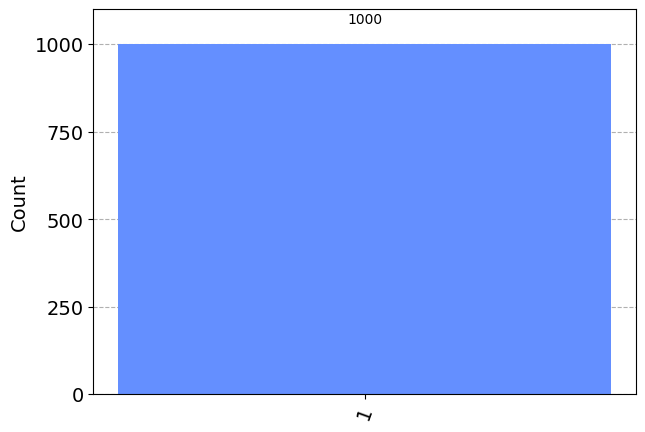

In [29]:
from qiskit import execute, Aer

job = execute(circuit, Aer.get_backend('aer_simulator'), shots=1000)
results = job.result()
counts = results.get_counts()
print(counts)
# print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [23]:
def ancilla_intepreter(ancilla_measuremnt, num_1, num_2):
    if ancilla_measuremnt == "100":
        return "{} == {}".format(num_1, num_2)
    elif ancilla_measuremnt == "010":
        return "{} > {}".format(num_1, num_2)
    elif ancilla_measuremnt == "001":
        return "{} < {}".format(num_1, num_2)
    else:
        return "error"
    
mapped = {
    "100": -4,
    "101": -3,
    "110": -2,
    "111": -1,
    "000": 0,
    "001": 1,
    "010": 2,
    "011": 3
}
wrong_results = []
right_results = []
for first_num in range(2**(num_uncertainty_qubits)):
    for second_num in range(2**(num_uncertainty_qubits)):
        # circuit
        first_num_register = QuantumRegister(num_uncertainty_qubits, 'first_num')
        second_num_register = QuantumRegister(num_uncertainty_qubits, 'second_num')
        ancilla = AncillaRegister(1, 'ancilla')
        compare_register = QuantumRegister(3, 'compare')
        results = ClassicalRegister(3, 'results')

        circuit = QuantumCircuit(first_num_register, second_num_register, ancilla, compare_register, results)

        binary_first = loadNumber(circuit, first_num_register, first_num)
        binary_second = loadNumber(circuit, second_num_register, second_num)

        circuit.append(Qcomparator, first_num_register[:] + second_num_register[:] + ancilla[:]+ compare_register[:])
        circuit.measure(compare_register, results)

        job = execute(circuit, Aer.get_backend('aer_simulator'), shots=1000)
        results = job.result()
        counts = results.get_counts()
        comparator_result = list(counts.keys())[0]
        
        if not eval(ancilla_intepreter(comparator_result, first_num, second_num)):
            wrong_results.append((first_num, second_num, binary_first, binary_second, comparator_result, ancilla_intepreter(comparator_result, first_num, second_num)))
        else:
            right_results.append((first_num, second_num, binary_first, binary_second, comparator_result, ancilla_intepreter(comparator_result, first_num, second_num)))
        print(f'first_num: {mapped[binary_first]} ({binary_first}), second_num: {mapped[binary_second]} ({binary_second}), counts: {counts}')
        print(ancilla_intepreter(comparator_result, first_num, second_num))
        print(eval(ancilla_intepreter(comparator_result, mapped[binary_first], mapped[binary_second])))
        
with open('comparator_wrong_results.txt', 'w') as f:
    for item in wrong_results:
        f.write("%s\n" % str(item))
        
with open('comparator_right_results.txt', 'w') as f:
    for item in right_results:
        f.write("%s\n" % str(item))
        

first_num: 0 (000), second_num: 0 (000), counts: {'100': 1000}
0 == 0
True
first_num: 0 (000), second_num: 1 (001), counts: {'001': 1000}
0 < 1
True
first_num: 0 (000), second_num: 2 (010), counts: {'001': 1000}
0 < 2
True
first_num: 0 (000), second_num: 3 (011), counts: {'001': 1000}
0 < 3
True
first_num: 0 (000), second_num: -4 (100), counts: {'010': 1000}
0 > 4
True
first_num: 0 (000), second_num: -3 (101), counts: {'010': 1000}
0 > 5
True
first_num: 0 (000), second_num: -2 (110), counts: {'010': 1000}
0 > 6
True
first_num: 0 (000), second_num: -1 (111), counts: {'010': 1000}
0 > 7
True
first_num: 1 (001), second_num: 0 (000), counts: {'010': 1000}
1 > 0
True
first_num: 1 (001), second_num: 1 (001), counts: {'100': 1000}
1 == 1
True
first_num: 1 (001), second_num: 2 (010), counts: {'001': 1000}
1 < 2
True
first_num: 1 (001), second_num: 3 (011), counts: {'001': 1000}
1 < 3
True
first_num: 1 (001), second_num: -4 (100), counts: {'010': 1000}
1 > 4
True
first_num: 1 (001), second_num:

In [16]:
from package.helper import Subtractor
from package.qArithmetic import QComp
import numpy as np
from qiskit.circuit.library import DraperQFTAdder
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from tqdm import tqdm


num_uncertainty_qubits = 3

comparator = QComp(num_uncertainty_qubits + 1, num_uncertainty_qubits + 1)
adder = DraperQFTAdder(num_uncertainty_qubits+1, kind="half")
subtractor = Subtractor(num_uncertainty_qubits).circuit



def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = bin(number)[2:].zfill(register.size)
    # print(number_in_binary)
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == "1":
            circ.x(register[i])
    return circ


# fixed numbers
first_number = 7
second_number = 6

strike_price_1 = 5
strike_price_2 = 2

first_var_register = QuantumRegister(num_uncertainty_qubits, "var1")
first_ancilla_register = QuantumRegister(num_uncertainty_qubits, "ancilla1")
first_carry_register = QuantumRegister(1, "carry")

second_var_register = QuantumRegister(num_uncertainty_qubits, "var2")
second_ancilla_register = QuantumRegister(num_uncertainty_qubits, "ancilla2")
second_carry_register = QuantumRegister(1, "carry2")
second_carry_register_copy = QuantumRegister(1, "carry2_copy")

comparator_carry = QuantumRegister(1, "comparator_carry")
comparator_ancilla = QuantumRegister(3, "comparator_ancilla")

adder_ancilla = QuantumRegister(1, "adder_ancilla")

objective_register = QuantumRegister(1, "objective")
classical_measurement = ClassicalRegister(3, "classical_measurement")
classical_measurement_2 = ClassicalRegister(2, "classical_measurement_2")

circuit = QuantumCircuit(
    first_var_register,
    first_ancilla_register,
    first_carry_register,
    second_var_register,
    second_ancilla_register,
    second_carry_register,
    second_carry_register_copy,
    comparator_carry,
    comparator_ancilla,
    adder_ancilla,
    classical_measurement,
)

# load numbers
loadNumber(
    circuit,
    first_var_register,
    first_number,
)
loadNumber(
    circuit,
    second_var_register,
    second_number,
)

# load strike prices
loadNumber(
    circuit,
    first_ancilla_register,
    strike_price_1,
)
loadNumber(
    circuit,
    second_ancilla_register,
    strike_price_2,
)
circuit.append(
    subtractor,
    first_var_register[:] + first_ancilla_register[:] + [first_carry_register[0]],
)
circuit.append(
    subtractor,
    second_var_register[:] + second_ancilla_register[:] + [second_carry_register[0]],
)

# circuit.x(first_carry_register[0])
# circuit.x(second_carry_register[0])
circuit.append(
    comparator,
    first_ancilla_register[:]
    + first_carry_register[:]
    + second_ancilla_register[:]
    + second_carry_register[:]
    + comparator_carry[:]
    + comparator_ancilla[:],
)
# circuit.append(
#     adder,
#     first_ancilla_register[:] 
#     + first_carry_register[:]
#     + second_ancilla_register[:]
#     + second_carry_register[:]
#     + adder_ancilla[:],
# )

circuit.measure(comparator_ancilla, classical_measurement)
circuit.draw()



┌───┐┌─────────────┐                    
                 var1_0: ┤ X ├┤0            ├────────────────────
                         ├───┤│             │                    
                 var1_1: ┤ X ├┤1            ├────────────────────
                         ├───┤│             │                    
                 var1_2: ┤ X ├┤2            ├────────────────────
                         ├───┤│             │┌─────────┐         
             ancilla1_0: ┤ X ├┤3 subtractor ├┤0        ├─────────
                         └───┘│             ││         │         
             ancilla1_1: ─────┤4            ├┤1        ├─────────
                         ┌───┐│             ││         │         
             ancilla1_2: ┤ X ├┤5            ├┤2        ├─────────
                         └───┘│             ││         │         
                  carry: ─────┤6            ├┤3        ├─────────
                              ├─────────────┤│         │         
                 var2_0: ─────┤0            ├┤         ├─────────
                         ┌───┐│             ││         │         
                 var2_1: ┤ X ├┤1            ├┤         ├─────────
                         ├───┤│             ││         │         
                 var2_2: ┤ X ├┤2            ├┤         ├─────────
                         └───┘│             ││         │         
             ancilla2_0: ─────┤3 subtractor ├┤4        ├─────────
                         ┌───┐│             ││   QComp │         
             ancilla2_1: ┤ X ├┤4            ├┤5        ├─────────
                         └───┘│             ││         │         
             ancilla2_2: ─────┤5            ├┤6        ├─────────
                              │             ││         │         
                 carry2: ─────┤6            ├┤7        ├─────────
                              └─────────────┘│         │         
            carry2_copy: ────────────────────┤         ├─────────
                                             │         │         
       comparator_carry: ────────────────────┤8        ├─────────
                                             │         │┌─┐      
   comparator_ancilla_0: ────────────────────┤9        ├┤M├──────
                                             │         │└╥┘┌─┐   
   comparator_ancilla_1: ────────────────────┤10       ├─╫─┤M├───
                                             │         │ ║ └╥┘┌─┐
   comparator_ancilla_2: ────────────────────┤11       ├─╫──╫─┤M├
                                             └─────────┘ ║  ║ └╥┘
          adder_ancilla: ────────────────────────────────╫──╫──╫─
                                                         ║  ║  ║ 
classical_measurement: 3/════════════════════════════════╩══╩══╩═
                                                         0  1  2

In [17]:
from qiskit import execute, Aer
job = execute(circuit, Aer.get_backend('aer_simulator'), shots=1000)
results = job.result()
counts = results.get_counts()
print(counts)

{'001': 1000}
